In [1]:
# load libraries
import pandas as pd
import os
import numpy as np
import datetime
from torch.utils.data import Dataset, DataLoader
from torch import save

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# change me, have to point to the Meteotrentino drive folder
wk =  "/content/drive/My Drive/10. Meteotrentino/"

dataset_path = wk+"DatasetPytorch/"

sensor_type = "pioggia"

# sensor_dataset = "pioggia1"

# sensor = "T0065"



In [4]:
file_name_test = "test_join_tsf.pt"
file_name_train = "train_join_tsf.pt"

file_test_to_read_path = os.path.join(wk, dataset_path, sensor_type, file_name_test)
file_train_to_read_path = os.path.join(wk, dataset_path, sensor_type, file_name_train)

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
  def __init__(self, df_train, df_test):
    features = df_train.drop(['sensor_code','in_datetime'],axis=1)
    target = df_test.drop(['sensor_code','in_datetime']+[f"val_{idx}" for idx in range(n_previsions)],axis=1)
    self.features = torch.FloatTensor(np.array([list(features[i].values) for i in range(len(features.columns))]))
    self.target = torch.FloatTensor(np.array([list(target[i].values) for i in range(len(target.columns))]))
    self.sensor_code = np.array(df_train['sensor_code'].values) 
    self.in_datetime = df_train['in_datetime'].values
    labels = df_test[[f"val_{idx}" for idx in range(n_previsions)]]
    self.labels = torch.FloatTensor(np.array([list(labels[f"val_{i}"].values) for i in range(len(labels.columns))]))
    # to be explained
    self.features = self.features.permute((1,0,2))
    self.target = self.target.permute((1,0,2))
    self.labels = self.labels.permute((1,0,2))

  def __len__(self):
    return len(self.sensor_code)

  def __getitem__(self, idx):
    sensor_code = self.sensor_code[idx]
    date = self.in_datetime[idx]
    features = self.features[idx]
    labels = self.labels[idx]
    target = self.target[idx]
    return {"sensor_code": sensor_code, "date":date,"features": features, "target":target,"labels":labels}


def rolling_mean(tensor,window):
  shape = tensor.size()
  return tensor.reshape(shape[0],int(shape[1]/window),window,shape[2]).mean(dim=2)

In [6]:
from torch import save,load
dataset = {}
splits = ['train','test']
shuffle = {'train':True,'test':False}
dataset['train'] = load(file_train_to_read_path)
dataset['test'] = load(file_test_to_read_path)
# rolling average
dataset['train'].features = rolling_mean(dataset['train'].features,4)
dataset['train'].target = rolling_mean(dataset['train'].target,4)
dataset['test'].features = rolling_mean(dataset['test'].features,4)
dataset['test'].target = rolling_mean(dataset['test'].target,4)

# mean and std of train (target is small)
mean = dataset['train'].features.mean()
std = dataset['test'].features.std()

# for training, standardize the dataset
dataset['train'].features = (dataset['train'].features - mean)/std
dataset['train'].target = (dataset['train'].target - mean)/std
dataset['test'].features = (dataset['test'].features - mean)/std
dataset['test'].target = (dataset['test'].target - mean)/std


### dataloader
b_size = {'train':128,'test':128}#len(dataset['test'])}
dataloader = {x: torch.utils.data.DataLoader(dataset=dataset[x],
                                            batch_size=b_size[x],
                                            shuffle=shuffle[x],
                                            collate_fn=lambda x: x,
                                            drop_last=True)
                                            #num_workers=int(opt.workers),
                                            #worker_init_fn=(None if opt.manualseed == -1
                                            #else lambda x: np.random.seed(opt.manualseed)))
            for x in splits}

fatal: destination path 'AI-Challenge-HIT' already exists and is not an empty directory.


100%|██████████| 344/344 [00:06<00:00, 49.25it/s]


Epoch = 1
	Training Loss: 0.7189
	Test Loss: 0.7222


100%|██████████| 344/344 [00:06<00:00, 51.64it/s]


Epoch = 2
	Training Loss: 0.6957
	Test Loss: 0.4738


100%|██████████| 344/344 [00:06<00:00, 51.46it/s]


Epoch = 3
	Training Loss: 0.6509
	Test Loss: 0.4099


100%|██████████| 344/344 [00:06<00:00, 51.21it/s]


Epoch = 4
	Training Loss: 0.6426
	Test Loss: 0.4121


100%|██████████| 344/344 [00:06<00:00, 50.18it/s]


Epoch = 5
	Training Loss: 0.6436
	Test Loss: 0.5994


100%|██████████| 344/344 [00:06<00:00, 49.38it/s]


Epoch = 6
	Training Loss: 0.6619
	Test Loss: 0.5697


100%|██████████| 344/344 [00:06<00:00, 50.89it/s]


Epoch = 7
	Training Loss: 0.6533
	Test Loss: 0.5943


100%|██████████| 344/344 [00:06<00:00, 50.52it/s]


Epoch = 8
	Training Loss: 0.6484
	Test Loss: 0.3943


100%|██████████| 344/344 [00:06<00:00, 50.84it/s]


Epoch = 9
	Training Loss: 0.6533
	Test Loss: 0.5413


100%|██████████| 344/344 [00:06<00:00, 50.49it/s]

Epoch = 10
	Training Loss: 0.6434
	Test Loss: 0.4701


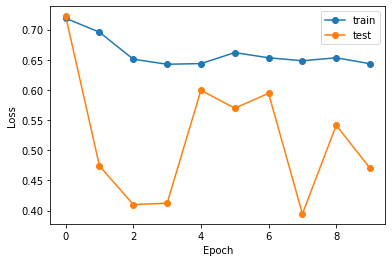

In [18]:
from collections.abc import Sequence
from importlib import reload  # Python 3.4+
import torch
import sys
from torch import nn
# clone the libraries if not done 
!git clone https://github.com/eliazonta/AI-Challenge-HIT
sys.path.append("/content/AI-Challenge-HIT/python_code/notebooks/AnomalyDetection")
import LSTMs_multiple_stations
LSTMs_multiple_stations = reload(LSTMs_multiple_stations)
from LSTMs_multiple_stations import SingleLSTMCell,LSTM

SPLIT_NUMBER = 1
device = torch.device("cuda")
sequence_length = dataset['train'][0]['features'].size(0)
pred_length = dataset['train'][0]['target'].size(0)
# Instantiate the model with hyperparameters
model = LSTM(input_size=3, output_size=3, hidden_dim=64, num_layers=5, device = device)
train_loss = []
test_loss = []

# We'll also set the model to the device that we defined earlier (default is CPU)
# Daniele: Not sure if this is useless now, should check
model = model.to(device)
#model.load_state_dict(torch.load('T0065_rad_sol_model.pt', map_location=torch.device('cpu')))

# Define hyperparameters
lr = 1e-3

# Define Loss, Optimizer
criterion = nn.MSELoss()#CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

from tqdm import tqdm
n_epochs = 10
for epoch in range(1, n_epochs + 1):
    model.train()
    loss_train_batch = []
    for data in tqdm(dataloader['train'], leave=True, total=len(dataloader['train'])):
      # preparing the input
      batch_input_features = torch.stack([v["features"] for v in data]).to(device)
      target_features = torch.stack([v["target"] for v in data]).to(device)

      # feed the model
      output = model(batch_input_features,pred_length)
      output = output.to(device)[:,-pred_length:,:]
      loss_train = criterion(output, target_features)
      loss_train.backward() # Does backpropagation and calculates gradients
      optimizer.step() # Updates the weights accordingly
      loss_train_batch.append(loss_train.item())
    
    mean_train_loss = np.mean(loss_train_batch)
    model.eval()
    # try to use it if too much memory is used
    # with torch.no_grad():
    # preparing the input of test dataset
    data_test = next(iter(dataloader['test']))
    test_input_features = torch.stack([v["features"] for v in data_test]).to(device)
    test_target_features = torch.stack([v["target"] for v in data_test]).to(device)

    test_input_features_splitted = np.array_split(test_input_features, SPLIT_NUMBER)
    output_test_list = []
    for input_feature_split_subset in test_input_features_splitted:
      output_test_list.append(model(input_feature_split_subset,pred_length)[:,-pred_length:,:])
    output_test_flat = [item for item in output_test_list]
    output_test = torch.cat(output_test_flat)
    loss_test = criterion(output_test, test_target_features)
    train_loss.append(mean_train_loss)
    test_loss.append(loss_test.item())
    print("Epoch = " + str(epoch))
    print("\tTraining Loss: {:.4f}".format(mean_train_loss))
    print("\tTest Loss: {:.4f}".format(loss_test.item()))

    if mean_train_loss < 0.010:
        break

import matplotlib.pyplot as plt

plt.plot(train_loss,'o-',label="train")
plt.plot(test_loss,'o-',label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [19]:
torch.cuda.empty_cache()

In [20]:
# save model
torch.save(model.state_dict(),
           os.path.join(wk, "TrainedModels/", "joint_"+sensor_type+"_model.pt")
)


In [21]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
criterion = nn.MSELoss(reduction='none')
sample = dataset["test"]
### use below a list of min and max indexes in case of memory overflow, otherwise set to none
restriction = None#[10000,50000]

# device = torch.device("cuda")
# model = LSTM(input_size=3, output_size=3, hidden_dim=32, num_layers=3, device = device)
# model.load_state_dict(torch.load( os.path.join(wk, "TrainedModels/", "joint_"+sensor_type+"_model.pt"), map_location=device))
# model = model.to(device)
SPLIT_NUMBER = 50
index_array_to_split = np.int64(np.linspace(0, len(sample)-1, len(sample)))
index_array_splitted = np.array_split(index_array_to_split, SPLIT_NUMBER)

def extract_quantity_from_dataset(dataset,label_of_quantity,indexes=None,device='cpu'):
  # returns a pytorch array of the given quantity
  # optional: restrict the dataset to some indexes (for memory allocation reasons)
  if(indexes):
    pt_tensor = torch.stack([dataset[i][label_of_quantity] for i in range(min(indexes),max(indexes)+1)]).to(device)
  else: pt_tensor = torch.stack([v[label_of_quantity] for v in dataset]).to(device)
  return pt_tensor

reconstructed_list = []

sample_tensor_validation_list = []
sample_tensot_features_list = []
sample_tensor_target_list = []
loss_list = []

for k in index_array_splitted:
  restriction = [k[0  ], k[-1]]
  sample_tensor_validation = extract_quantity_from_dataset(sample,"labels",restriction)
  sample_tensor_features = extract_quantity_from_dataset(sample,"features",restriction,device=device)
  sample_tensor_target = extract_quantity_from_dataset(sample,"target",restriction,device=device)

  sample_tensor_validation_list.append(sample_tensor_validation)
  sample_tensot_features_list.append(sample_tensor_features)
  sample_tensor_target_list.append(sample_tensor_target)

  sensor_code = [v['sensor_code'] for v in sample][0]
  date = pd.to_datetime([v['date'] for v in sample]).strftime("%d/%m/%Y %H:%M") 

  

  model.eval()
  with torch.no_grad():
    reconstructed_list.append( model(sample_tensor_features,pred_length) )
  reconstructed = reconstructed_list[-1]
  
  loss_list.append(criterion(reconstructed[:,-pred_length:]*std + mean, sample_tensor_target*std + mean).mean(dim=1))

In [29]:
reconstructed = torch.cat( [x for x in reconstructed_list])
# print(reconstructed.size())
loss = torch.cat([x for x in loss_list])
sample_tensor_validation = torch.cat([x for x in sample_tensor_validation_list])
sample_tensor_features = torch.cat([x for x in sample_tensot_features_list])
sample_tensor_target = torch.cat ([x for x in sample_tensor_target_list])
# Find the data with highest loss

TOP_K_loss = 10

top_loss, top_loss_indexes = torch.topk(loss, TOP_K_loss, dim=0)
lowest_loss, lowest_loss_indexes = torch.topk(loss, TOP_K_loss, dim=0, largest=False)

In [30]:
n_previsions = len(sample_tensor_target[0])

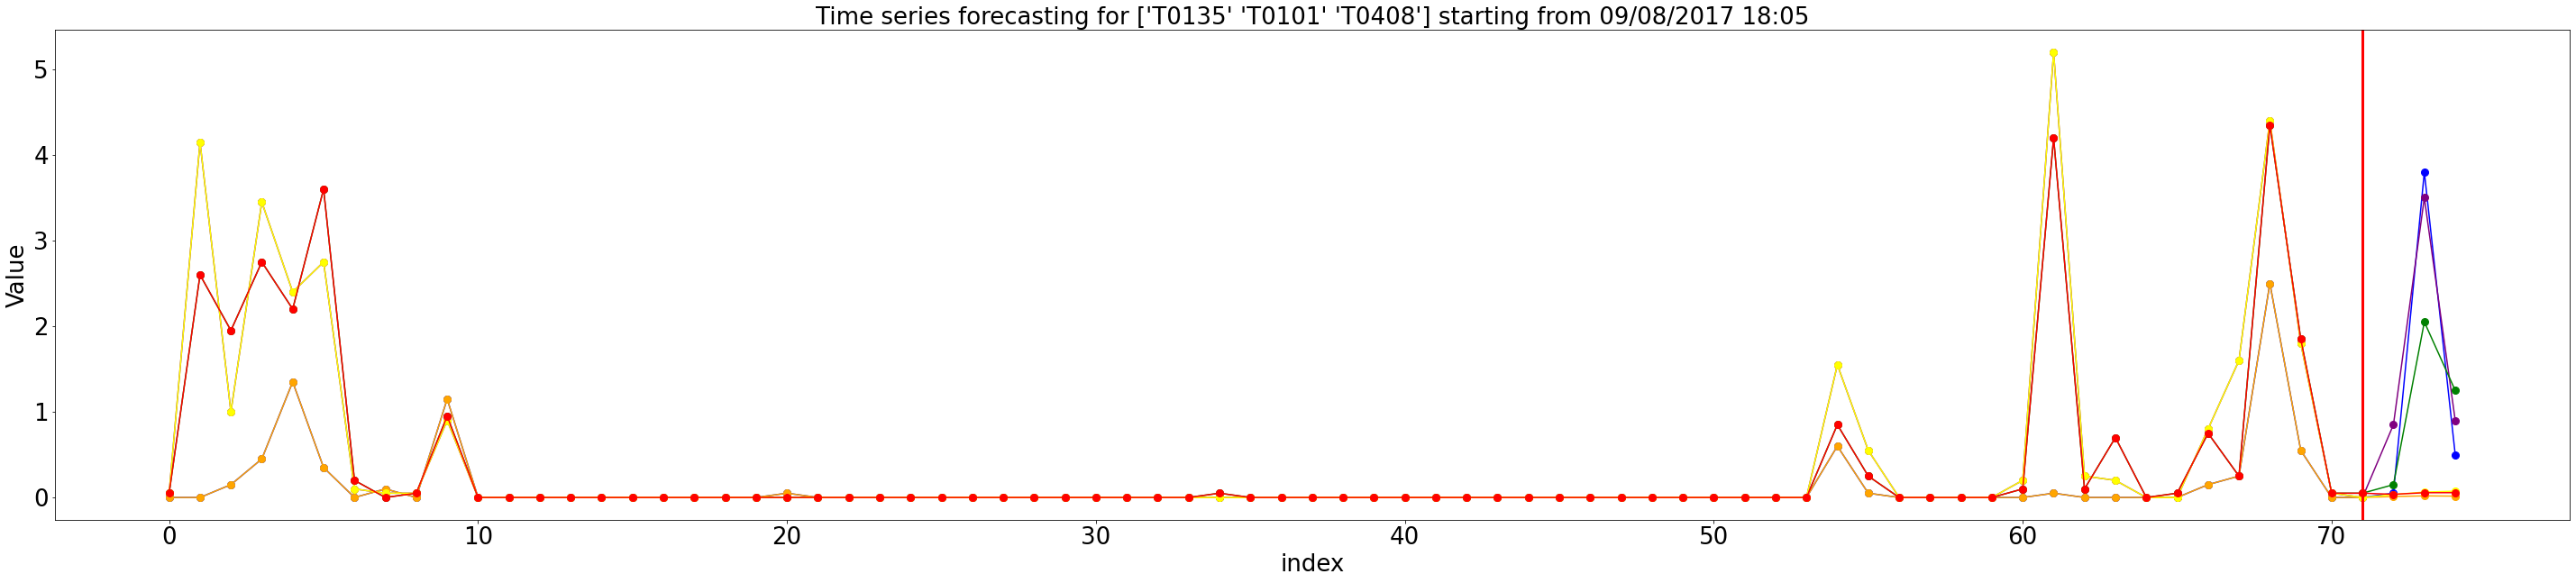

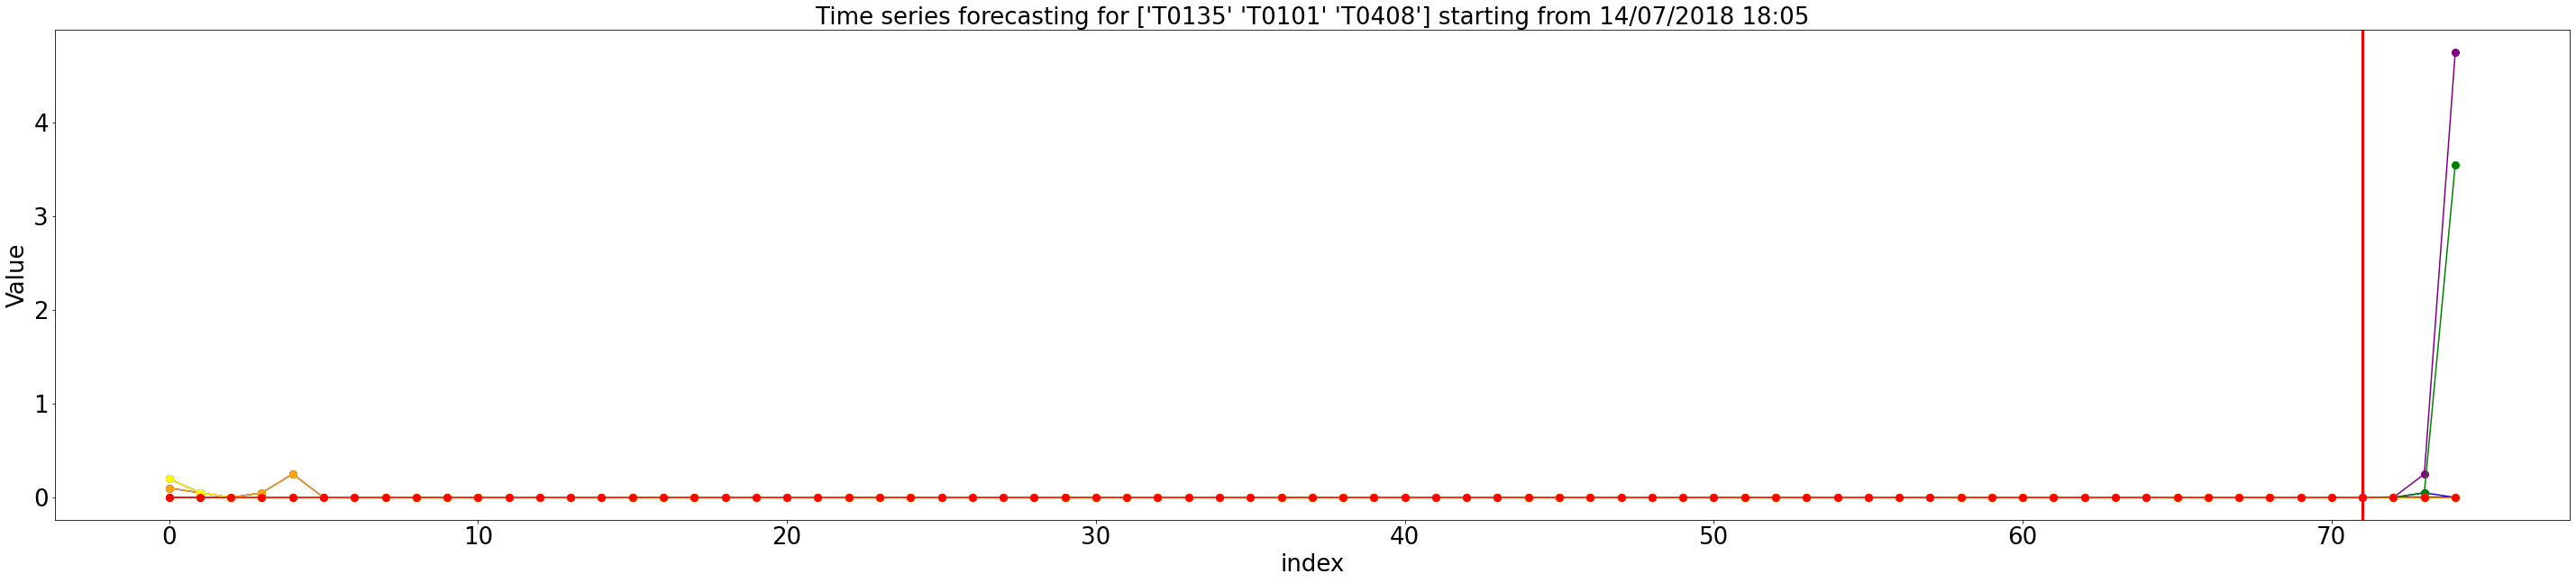

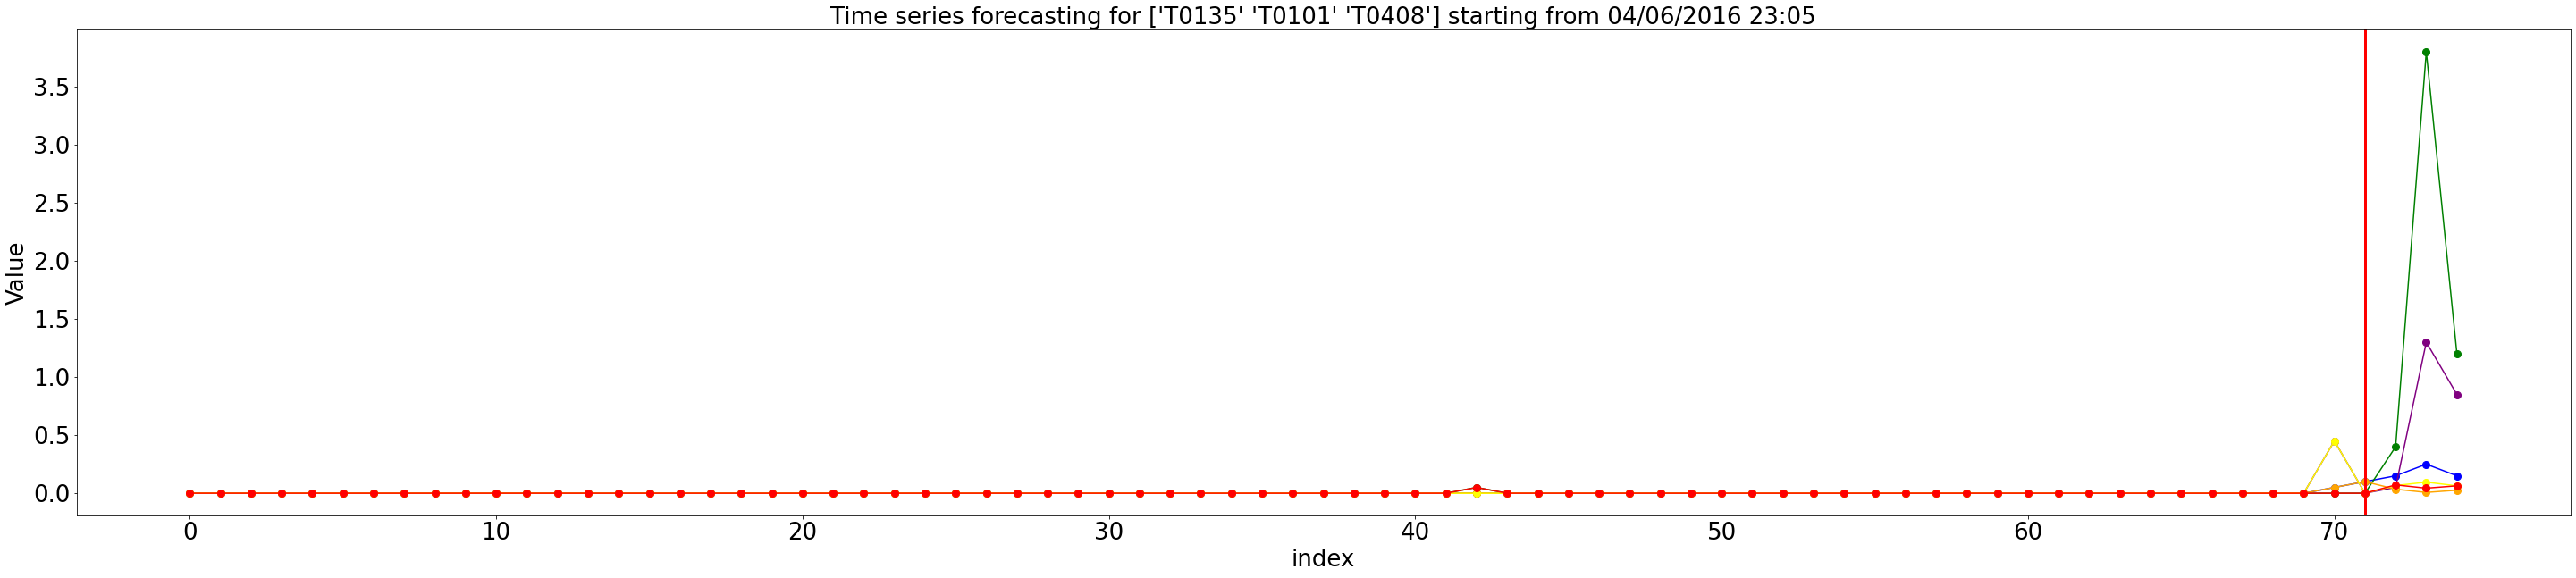

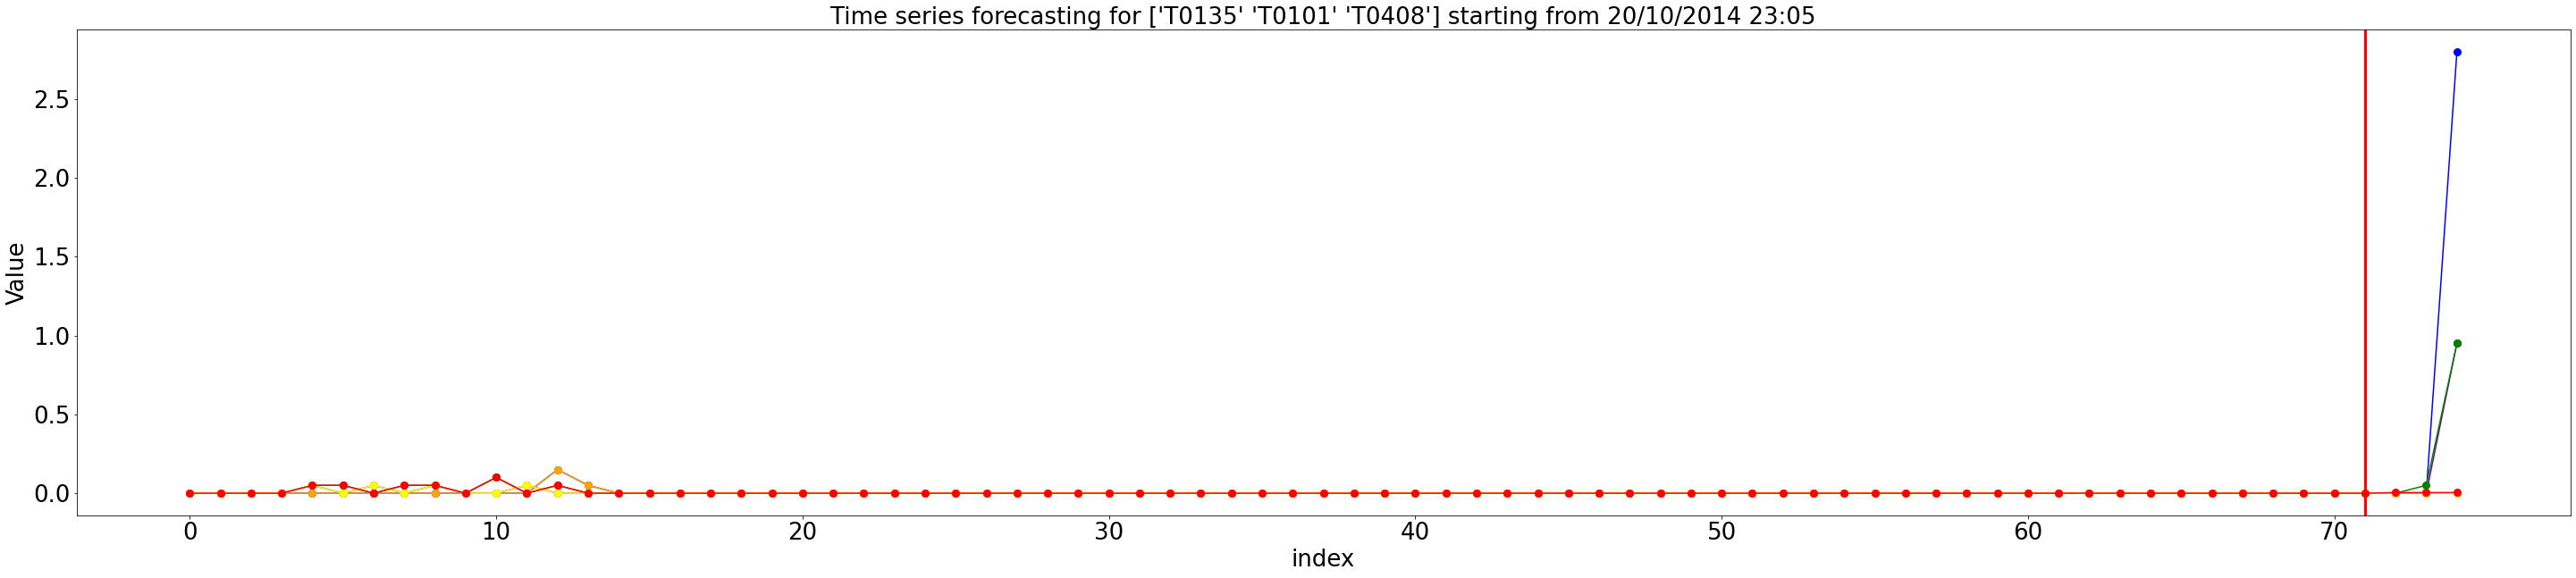

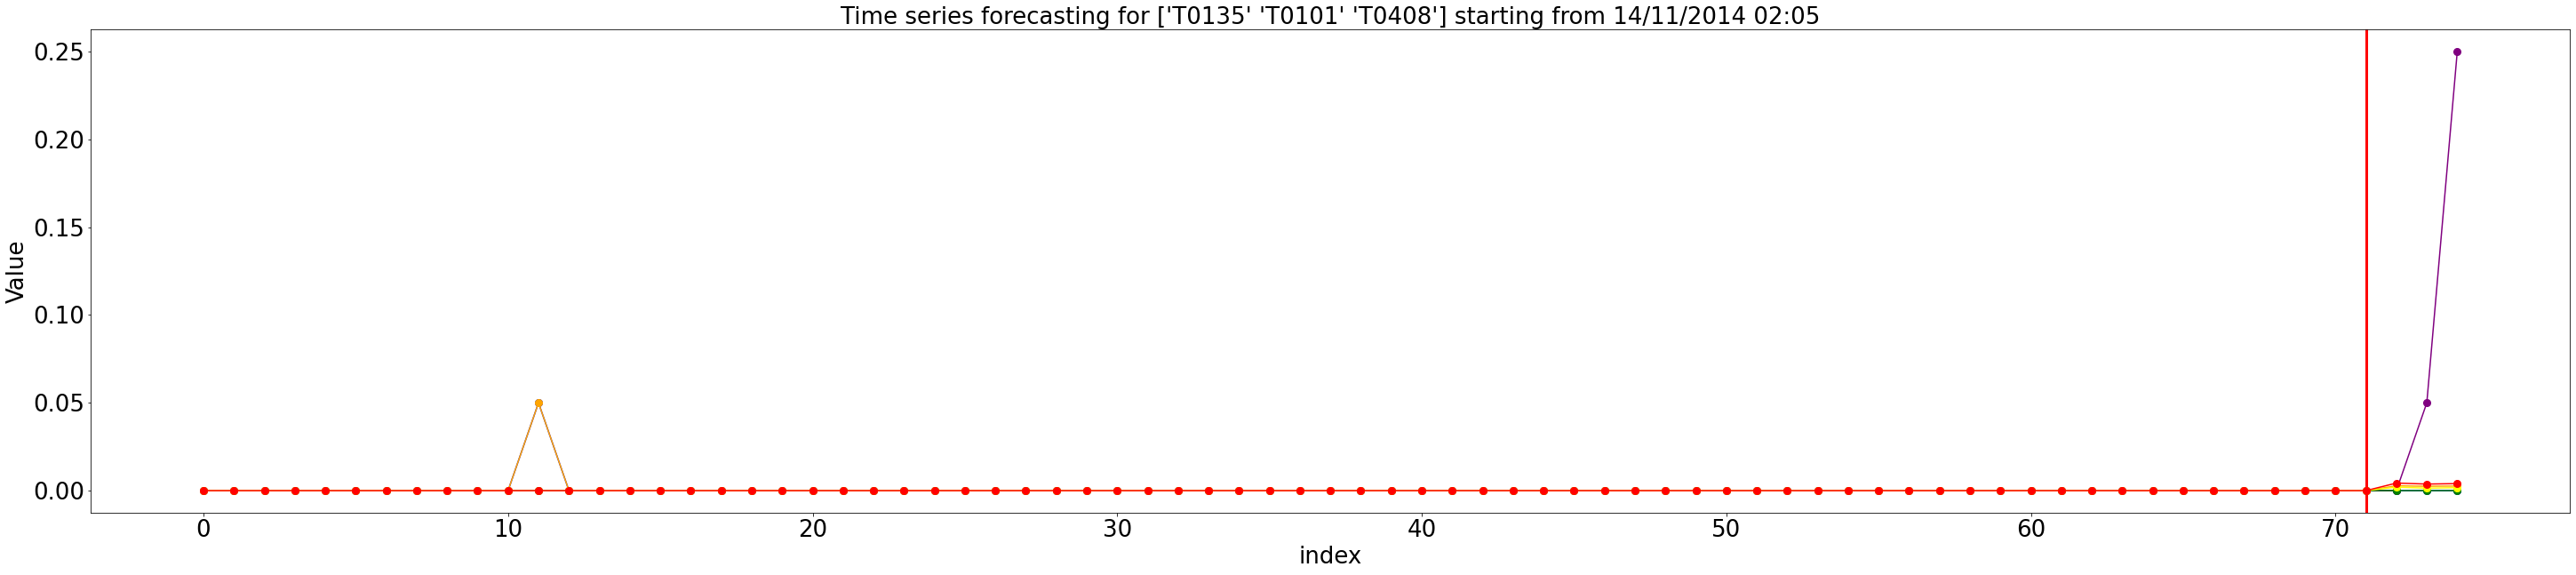

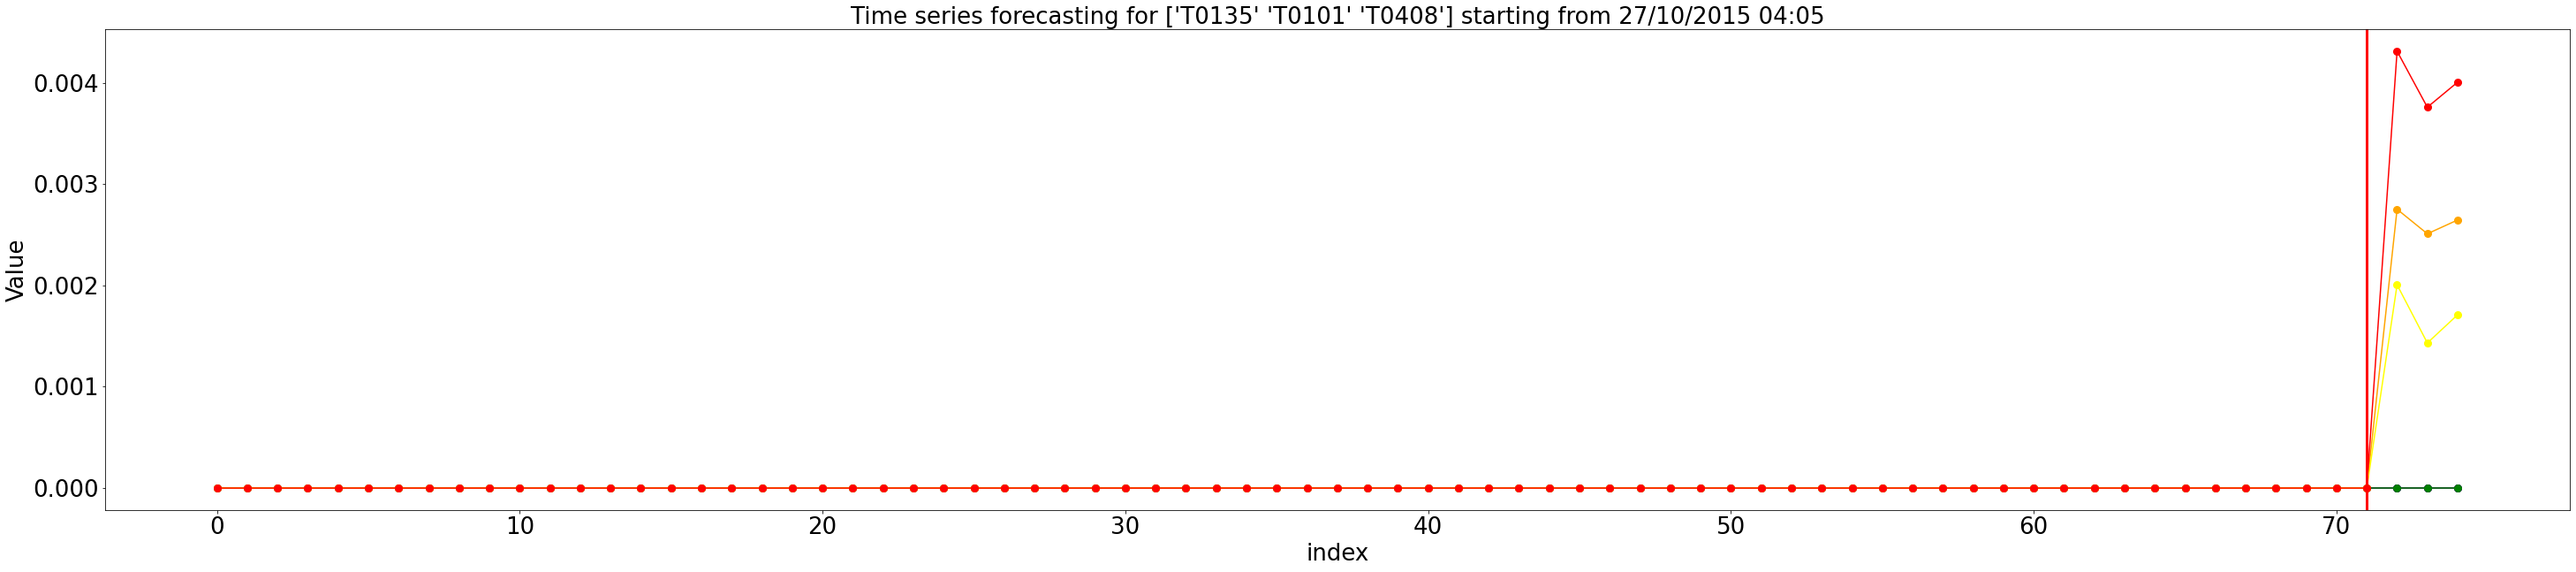

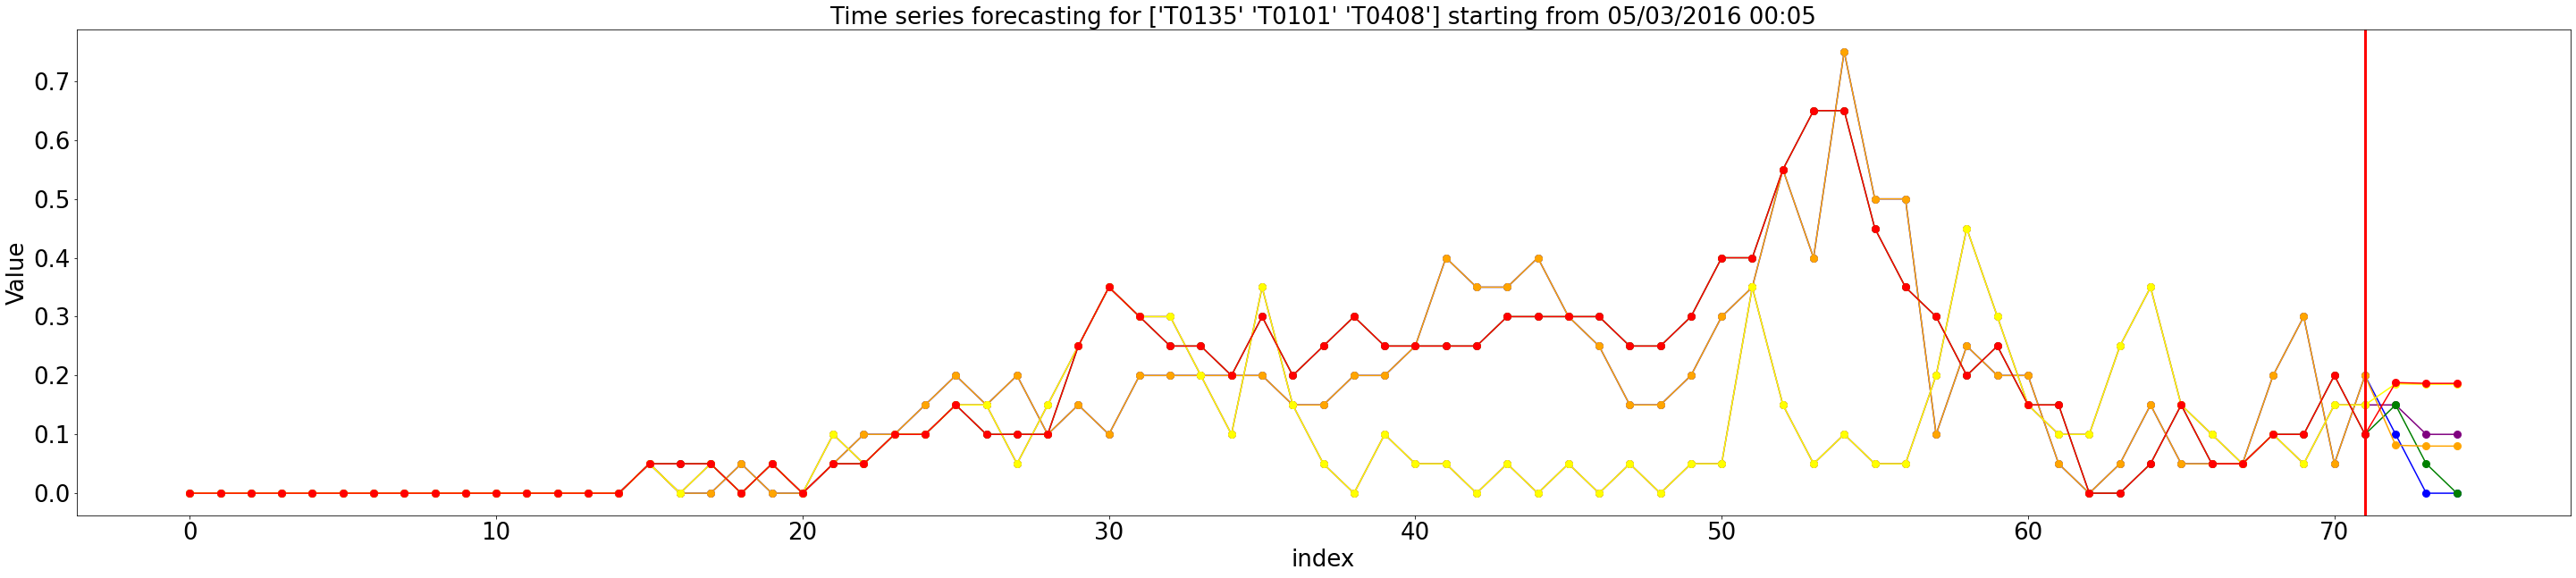

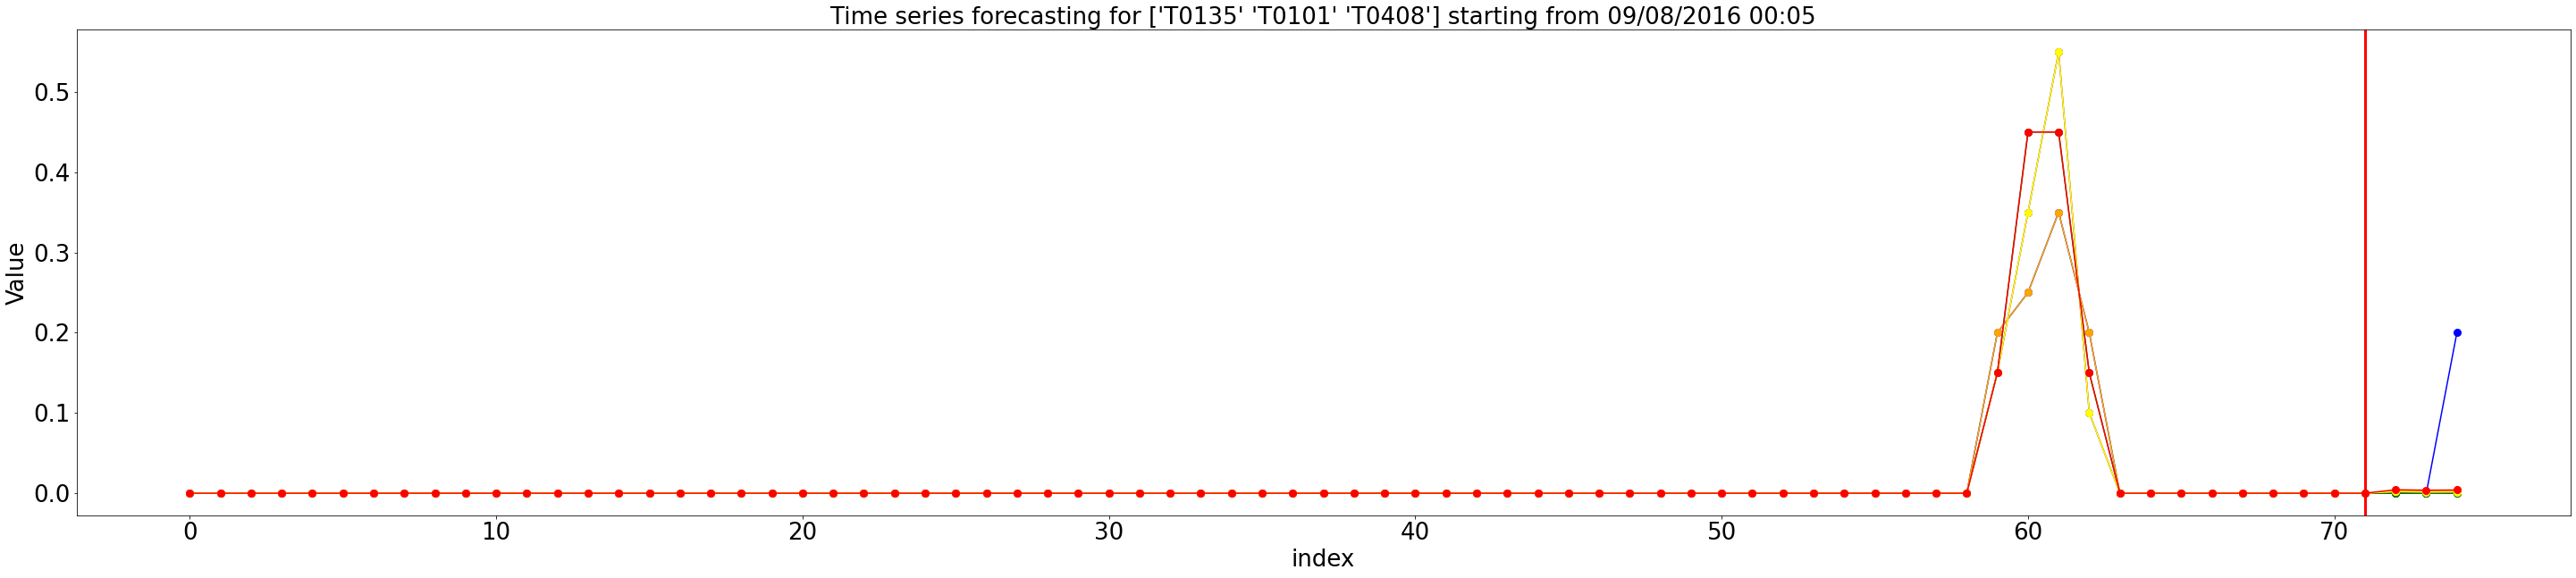

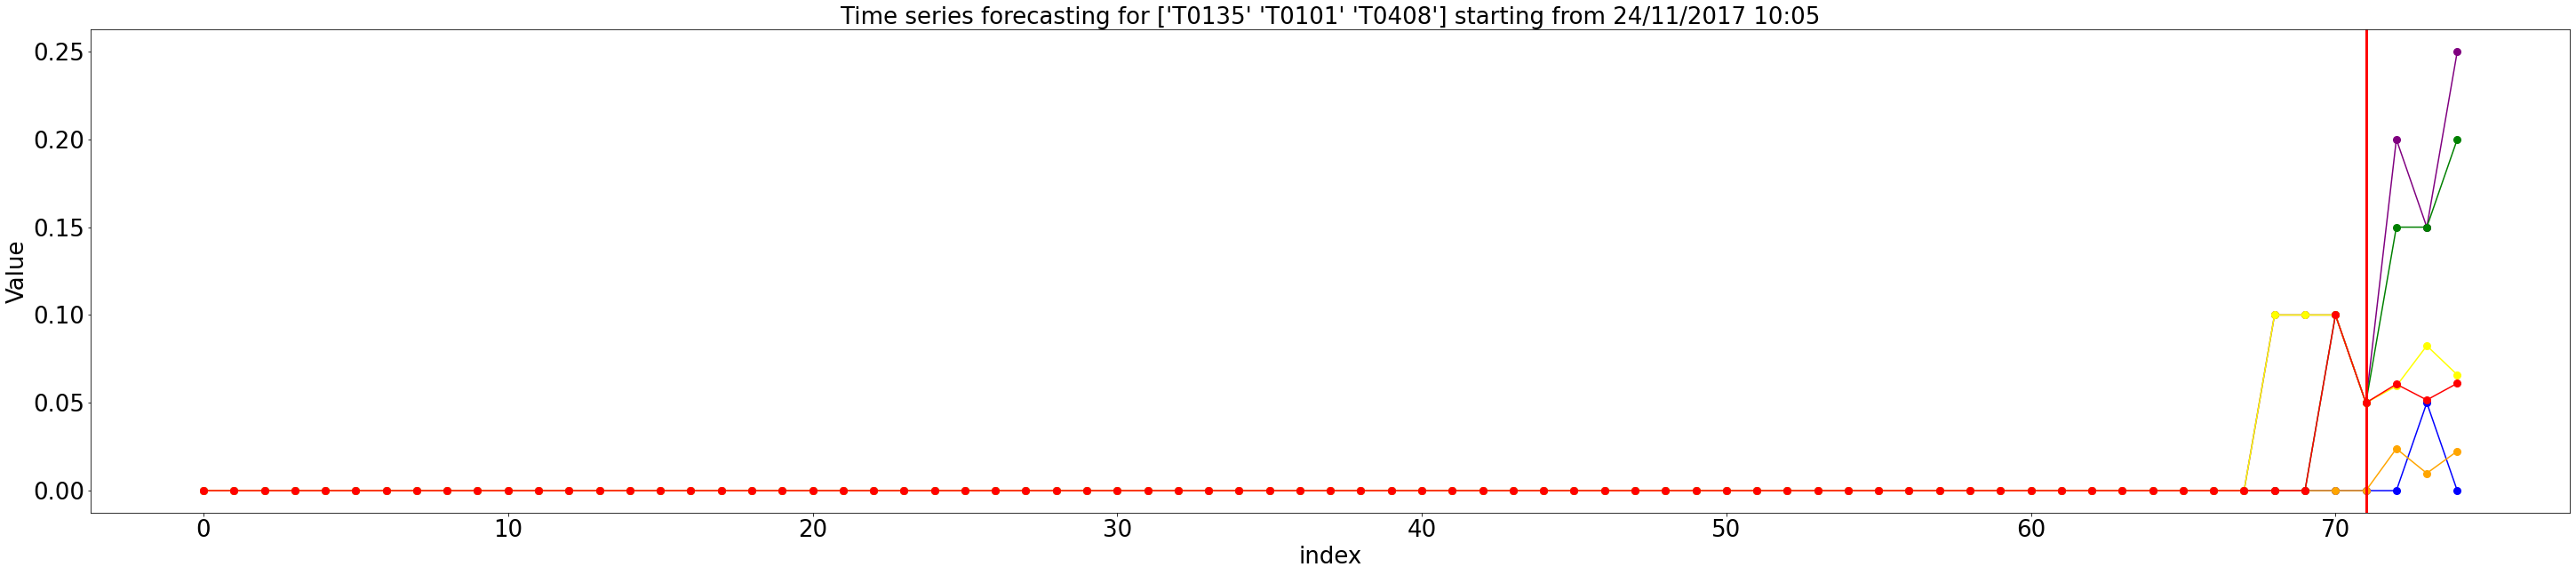

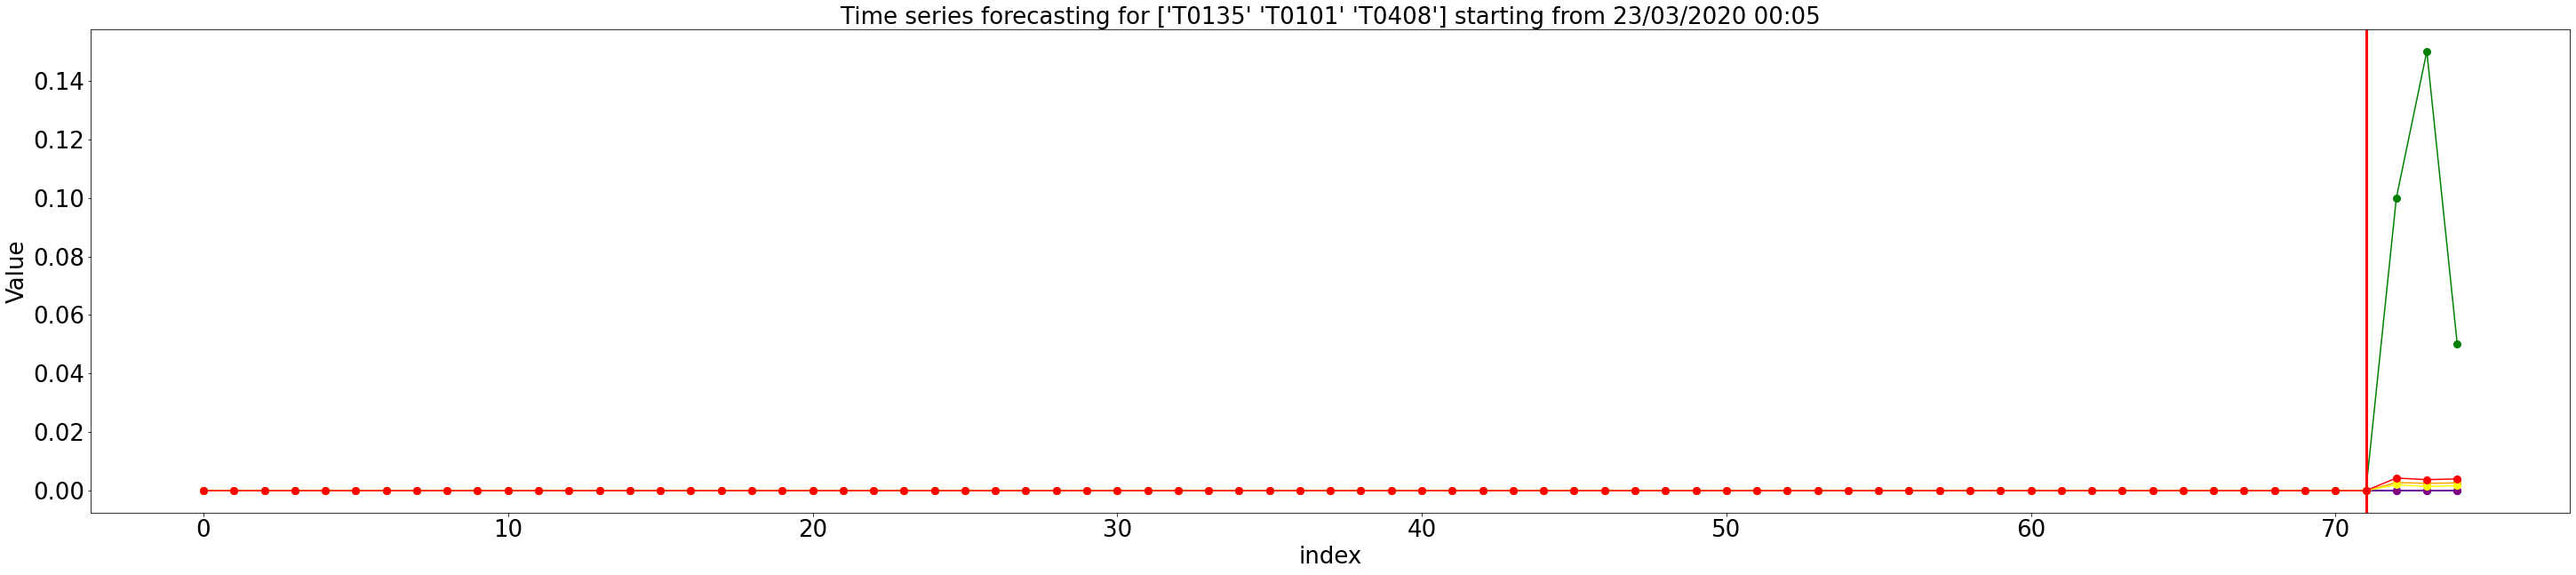

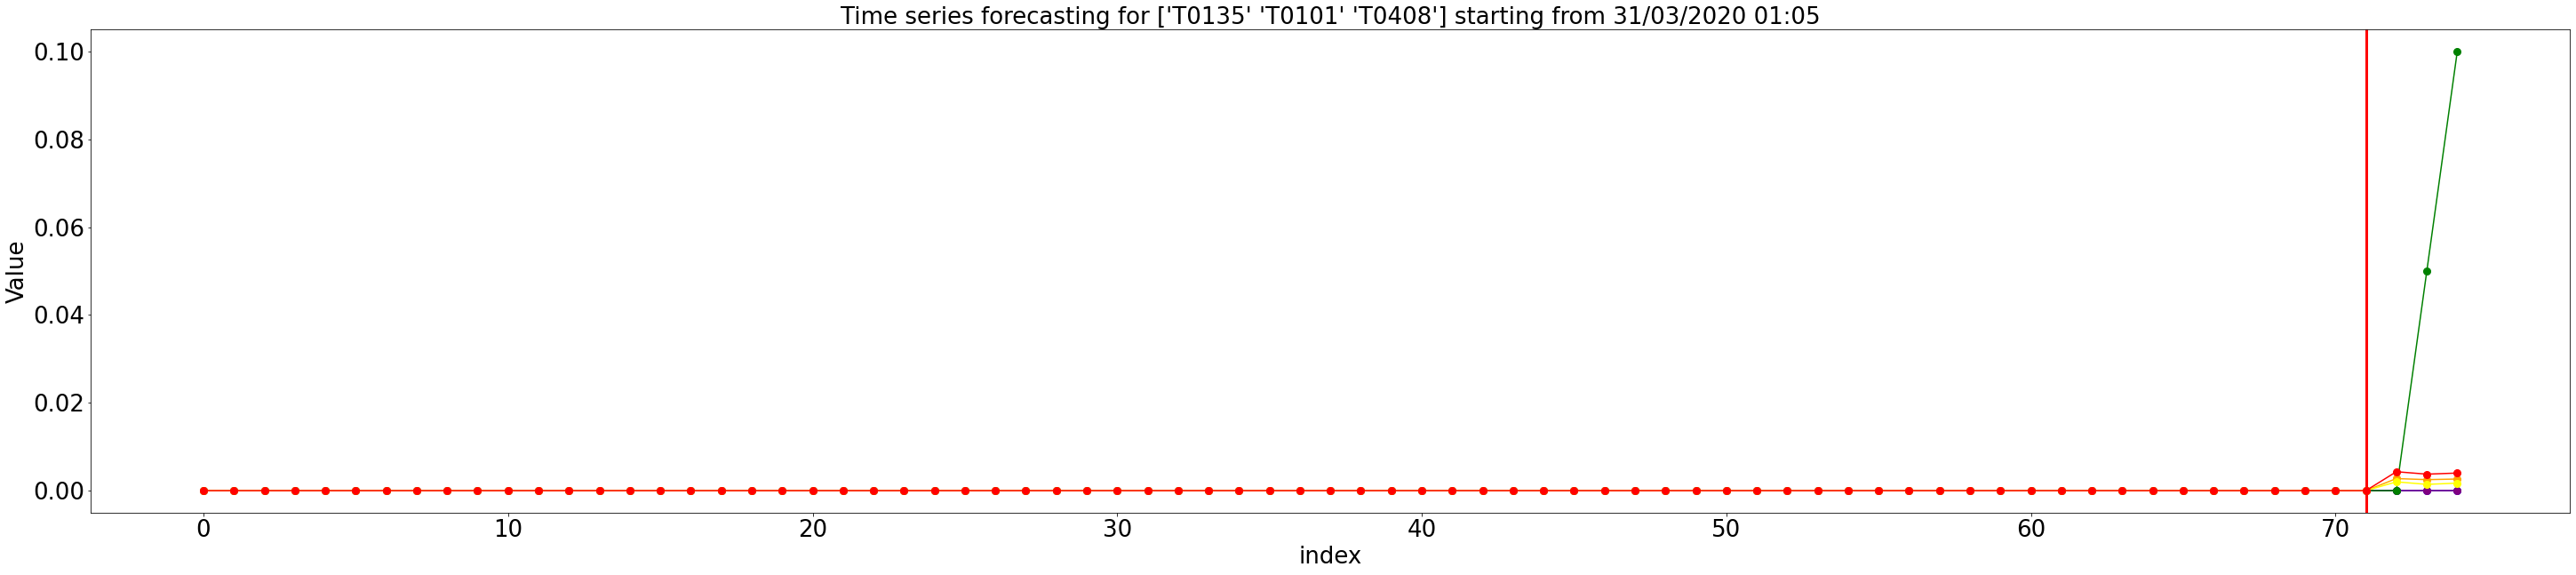

In [31]:
###
### PLOT THE TOP_K_loss EXAMPLES WITH LARGEST LOSS
### AND THE VALIDATED ANOMALIES
###
top_loss_indexes_list = list(top_loss_indexes[0].cpu().numpy())
lowest_loss_indexes_list = list(lowest_loss_indexes[0].cpu().numpy())
# append validated anomalies (to be cleaned)
validated_anomalies = list(np.unique((sample_tensor_validation != 1).nonzero(as_tuple=True)[0].numpy()))
# print(validated_anomalies)
top_loss_indexes_list.extend(validated_anomalies)
ts_len = sample_tensor_features.size(1)

# for i in [11030, 11031, 11032, 11033, 11034, 11035, 11036, 11037]:#top_loss_indexes_list:#top_loss_indexes_list:
for i in top_loss_indexes_list:
  f = plt.figure()
  f.set_figwidth(50)
  f.set_figheight(10)
  # single_date = str(date[i])
  plt.title(f'Time series forecasting for {sensor_code} starting from {date[i]}' ,fontsize = 26)
  plt.ylabel('Value',fontsize=26)
  plt.xlabel('index',fontsize=26)
  plt.xticks(fontsize=26)
  plt.yticks(fontsize=26)
  
  # find the outliers according to the validation
  # y_outliers_0 = np.where(sample_tensor_validation[i][:,0].to("cpu") == 1, np.NaN, (sample_tensor_target[i][:,0]*std + mean).to("cpu"))
  # y_outliers_1 = np.where(sample_tensor_validation[i][:,1].to("cpu") == 1, np.NaN, (sample_tensor_target[i][:,0]*std + mean).to("cpu"))
  # y_outliers_2 = np.where(sample_tensor_validation[i][:,2].to("cpu") == 1, np.NaN, (sample_tensor_target[i][:,0]*std + mean).to("cpu"))
  
  # plt.xlim(96,102)
  original_signal = torch.cat((sample_tensor_features*std + mean, sample_tensor_target*std + mean), 1)[i]

  plt.plot(original_signal.to("cpu")[:,0], "o-",ms=8,color="blue")
  plt.plot(original_signal.to("cpu")[:,1], "o-",ms=8,color="purple")
  plt.plot(original_signal.to("cpu")[:,2], "o-",ms=8,color="green")
  
  # plt.text(0,max(original_signal),f'Reconstruction loss = {loss[i]}',fontsize=26)
  plt.plot((reconstructed[i][:,0]*std + mean).to("cpu"),"o-",ms=8,color="orange", label = 'predicted')
  plt.plot((reconstructed[i][:,1]*std + mean).to("cpu"),"o-",ms=8,color="yellow", label = 'predicted')
  plt.plot((reconstructed[i][:,2]*std + mean).to("cpu"),"o-",ms=8,color="red", label = 'predicted')
  
  # plt.plot(np.arange(ts_len,ts_len+n_previsions), y_outliers_0, "x-",ms=15,mew=10,color="red")
  # plt.plot(np.arange(ts_len,ts_len+n_previsions), y_outliers_1, "x-",ms=15,mew=10,color="red")
  # plt.plot(np.arange(ts_len,ts_len+n_previsions), y_outliers_2, "x-",ms=15,mew=10,color="red")

  plt.axvline(x=ts_len-1, color='red',lw=3)
  # plt.legend(fontsize=26)
  plt.show()
  # plt.savefig('T0010_temperature_anomaly.pdf')

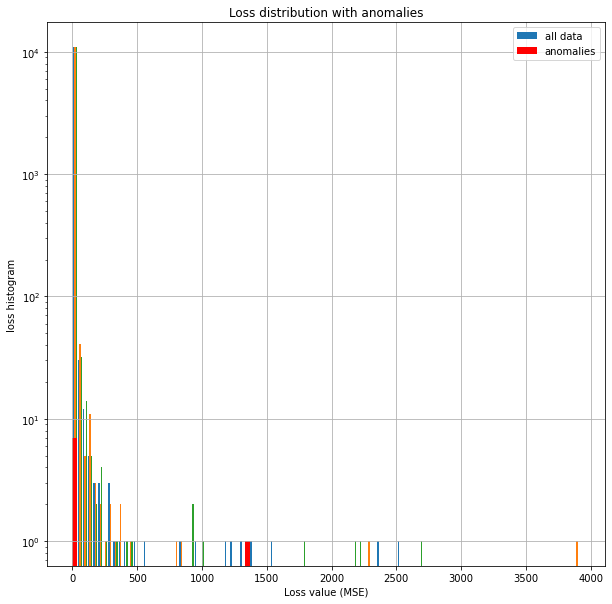

In [25]:
# HISTOGRAM
criterion = nn.MSELoss(reduction='none')
loss = criterion((reconstructed[:,-pred_length:]), (sample_tensor_target)).sum(dim=1)
arr = loss.cpu().detach().numpy()
extract_quantity_from_dataset(dataset['train'],"labels",None,device=device)
bool_validation = np.any(sample_tensor_validation.cpu().numpy()!=1,axis=1)
plt.figure(figsize=[10,10])
N_BINS = 100
bins_prec_hist = plt.hist(arr, bins = N_BINS, label = 'all data')[1]
plt.hist(loss[bool_validation].cpu(), bins = bins_prec_hist, label = 'anomalies', color = 'red')
plt.yscale('log')
plt.xlabel("Loss value (MSE)")
plt.ylabel("loss histogram")
plt.title("Loss distribution with anomalies")
plt.grid()
plt.legend()
plt.show()


In [ ]:
def rolling_mean(tensor,window):
  shape = tensor.size()
  return example.reshape(shape[0],int(shape[1]/win_size),win_size,shape[2]).mean(dim=2)
example = dataset['train'].features
rolled_mean = rolling_mean(example,4)

# f = plt.figure()
# f.set_figwidth(50)
# f.set_figheight(10)
# plt.plot(example)
# plt.plot(rolled_mean)

torch.Size([44121, 72, 3])


In [ ]:
print(dataset['train'].target.size())

torch.Size([44121, 12, 3])
